In [29]:
import pandas as pd
from pandas import np
%matplotlib inline
from matplotlib import pyplot as plt
from statsmodels import api as sm
tsa = sm.tsa

# Economic Forecasting Using Sentiment Analysis: Data exploration

Mali Akmanalp, Jose Morales Arilla, Kevin Shain

We have two different candidates as a possible indicator to use as a prediction target. Both are from the OECD.

The first dataset we'll look at is the [Consumer Confidence Index](https://en.wikipedia.org/wiki/Consumer_confidence_index), which is a monthly household survey that is benchmarked to have the value 100 for the year 1985.

In [30]:
df = pd.read_csv("./CCI.csv")
df = df[["TIME", "Value"]]
df.columns = ["time", "value"]

First, we can look at the CCI values over time: let's plot the values:

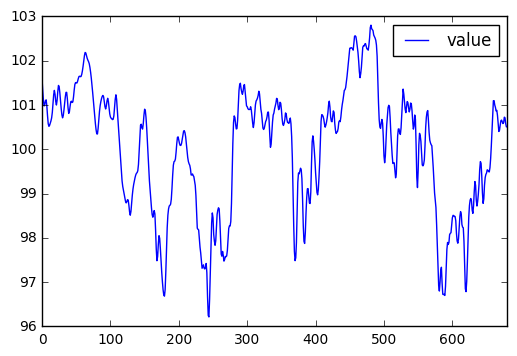

In [31]:
df.plot()

The CCI seems to mostly be centered around 100, and we're mostly interested in the changes that happen rather than the actual absolute value. To look at the change over time, we can also look at the differences of the values, which gives us a more interesting figure:

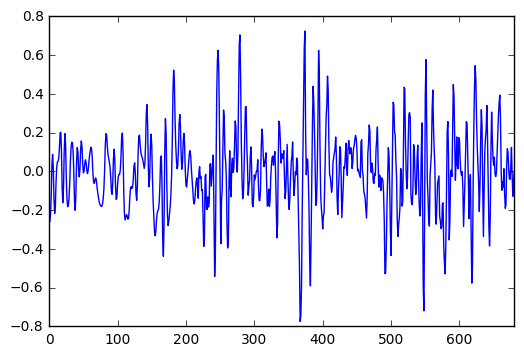

In [32]:
df.value.diff().plot()

We can also look at the distribution of the values:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115ff4c90>]], dtype=object)

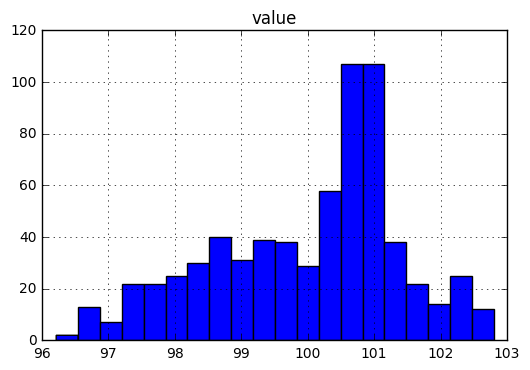

In [33]:
df.hist(bins=20)

Above 100 in general. Also, the above graphs look like they have a common time cycle trend and then noise around that. We can try to use the Hodrick–Prescott filter to separate the cycle and the trend:

In [34]:
a, b = tsa.filters.hpfilter(df.value)

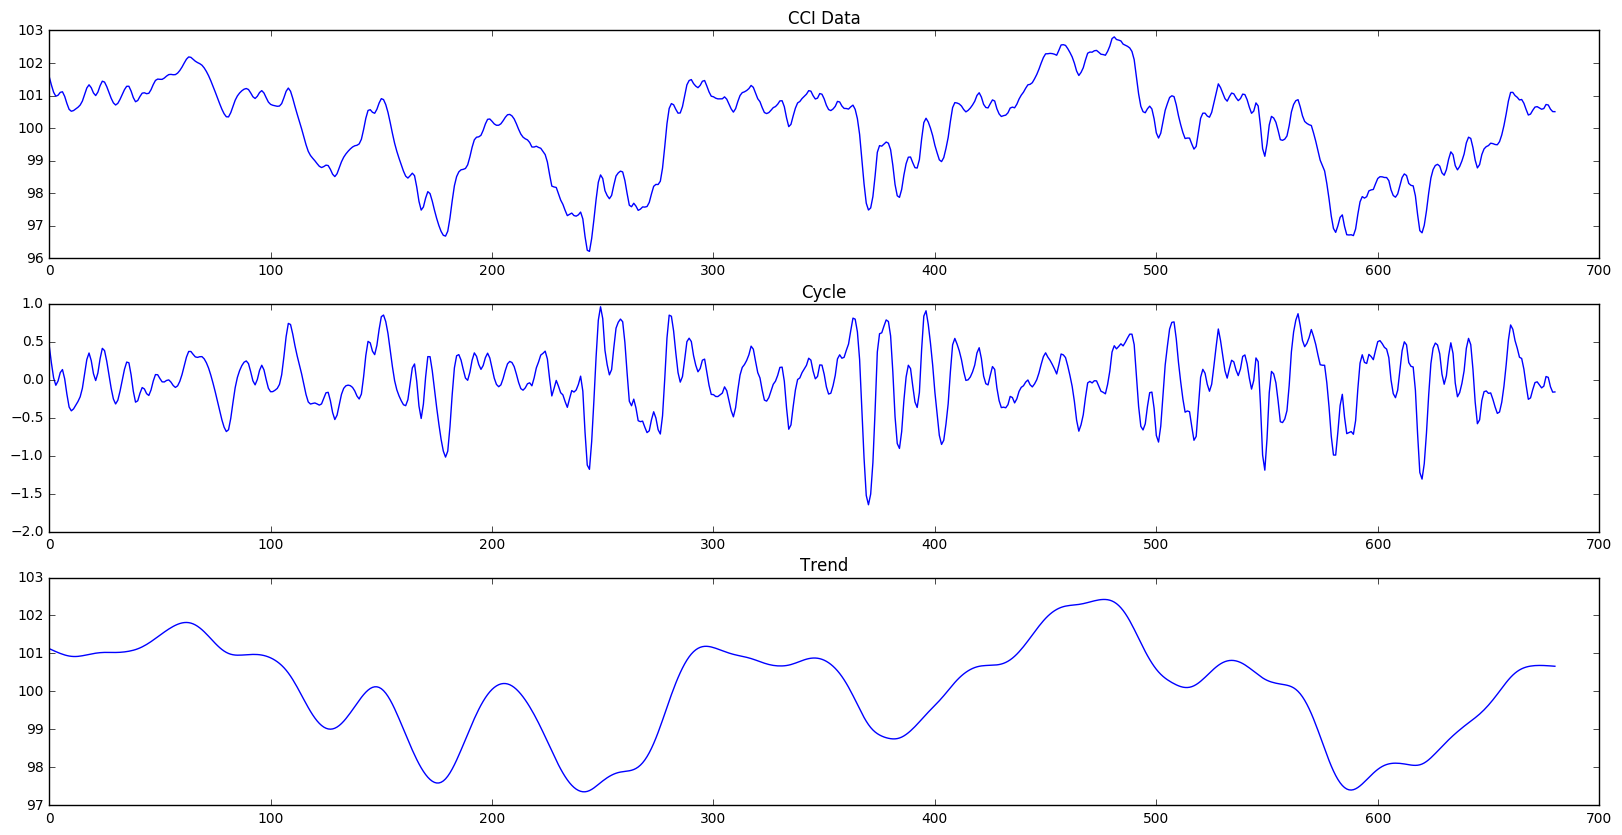

In [54]:
fig, ax = plt.subplots(3,1, figsize=(20, 10))
ax[0].plot(df.value)
ax[0].set_title("CCI Data")
ax[1].plot(a)
ax[1].set_title("Cycle")
ax[2].plot(b)
ax[2].set_title("Trend")

## Unit root test: Augmented Dickey-Fuller

Is the value stationary or not? We can use the [augmented Dickey-Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) to find out. The test has three different forms. We have to test all three forms, and if we find that the resulting statistic's absolute value is higher than the 1/5/10% critical values, we can conclude one way or the other for that form. Then we can do a simple vote among all three forms to get a conclusive result. To do this, we can use [statsmodels' implementation](http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.adfuller.html)

Here is one example:

Form 1: No drift and deterministic trends.

Result: Unit root (5%)

In [36]:
tsa.adfuller(df.value, regression="nc")

(-0.12518383149447002,
 0.64110728130924999,
 4,
 676,
 {'1%': -2.5690553334091941,
  '10%': -1.6164329575279444,
  '5%': -1.941404599830473},
 -1256.0739303517457)

Form 2: Drift only.

Result: Stationary (5%)

In [37]:
tsa.adfuller(df.value, regression="c")

(-3.2780882592117213,
 0.015886796188168056,
 14,
 666,
 {'1%': -3.4402068818114708,
  '10%': -2.5690862428193961,
  '5%': -2.8658894709126246},
 -1262.8076656501144)

Form 3: Drift + Deterministic trend

Result: Unit Root (5%)

In [38]:
tsa.adfuller(df.value, regression="ct")

(-3.269211945593832,
 0.071471314966745358,
 14,
 666,
 {'1%': -3.9724277884955539,
  '10%': -3.1309412069808631,
  '5%': -3.4171027175128486},
 -1260.8185912869417)

So, looking at all three results, we got 2/3 for unit root, so we can conclude that this is unit root, and not stationary. We can also look at the same for the difference:

In [39]:
tsa.adfuller(df.value.diff()[1:], regression="nc")

(-11.764285427996542,
 2.0497076446844373e-21,
 3,
 676,
 {'1%': -2.5690553334091941,
  '10%': -1.6164329575279444,
  '5%': -1.941404599830473},
 -1255.3356911531428)

In [40]:
tsa.adfuller(df.value.diff()[1:], regression="c")

(-11.755897224910441,
 1.1788975910714379e-21,
 3,
 676,
 {'1%': -3.4400605106273368,
  '10%': -2.5690518865761001,
  '5%': -2.8658249865874121},
 -1253.3404932351591)

In [41]:
tsa.adfuller(df.value.diff()[1:], regression="ct")

(-11.755278792074245,
 9.7538813824319566e-19,
 3,
 676,
 {'1%': -3.9722248029965295,
  '10%': -3.1308835135904487,
  '5%': -3.4170045949049879},
 -1251.4890884097554)

Here, it's pretty obviously stationary.

We can generalize this procedure into a function, like this:

In [42]:
def is_unit_root(data, threshold="5%"):
    
    nc = tsa.adfuller(data, regression="nc")
    c = tsa.adfuller(data, regression="c")
    ct = tsa.adfuller(data, regression="ct")
    
    votes = 0
    for test in [nc, c, ct]:
        if(abs(test[0]) < abs(test[4][threshold])):
            votes += 1
            
    return votes >= 2, {"nc": nc, "c":c, "ct":ct}

In [43]:
result, parameters = is_unit_root(df.value)

In [44]:
result

True

In [45]:
parameters["c"]

(-3.2780882592117213,
 0.015886796188168056,
 14,
 666,
 {'1%': -3.4402068818114708,
  '10%': -2.5690862428193961,
  '5%': -2.8658894709126246},
 -1262.8076656501144)

# Second option: CLI index

We can do similar diagnostics on a different but related metric, the CLI - the Composite Leading Indicator from the OECD that is an aggregate of many different statistics that is meant to show signals of change business cycles and the economy:

In [47]:
cli = pd.read_csv("./CLI.csv")
cli = cli[["TIME", "Value"]]
cli.columns = ["time", "value"]

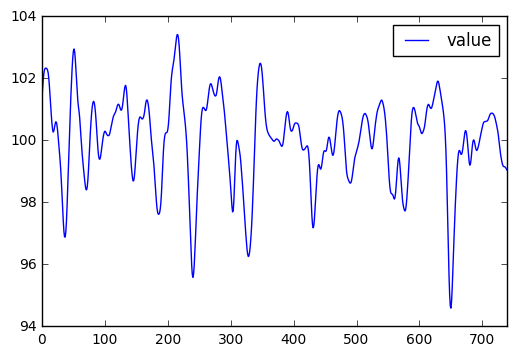

In [49]:
cli.plot()

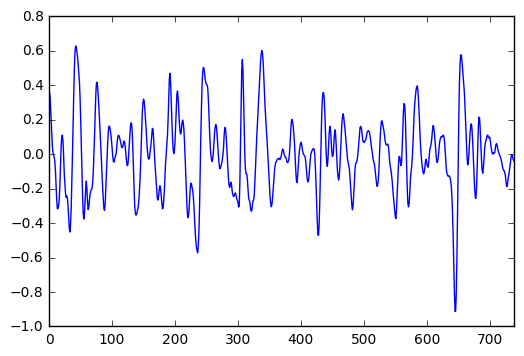

In [50]:
cli.value.diff().plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118c2e850>]], dtype=object)

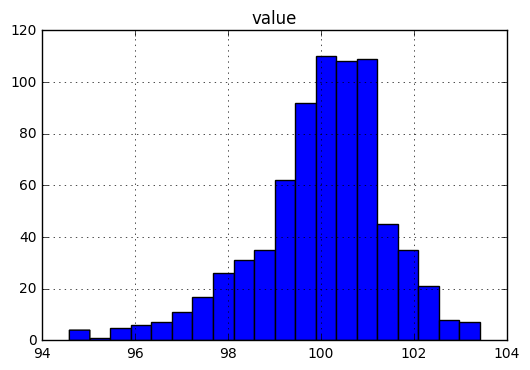

In [56]:
cli.hist(bins=20)

In [57]:
a, b = tsa.filters.hpfilter(cli.value)

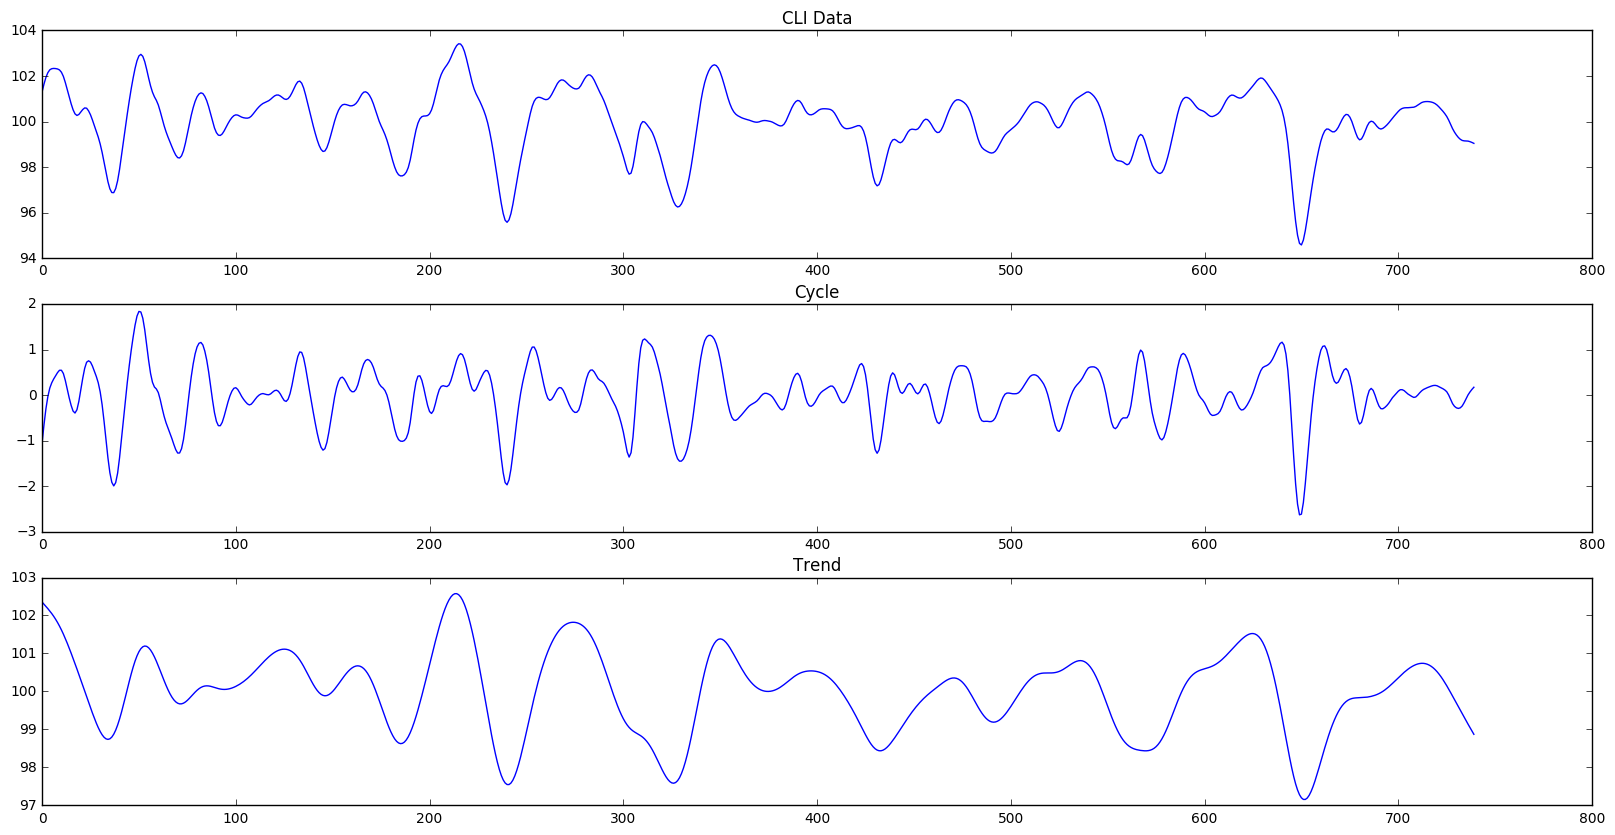

In [59]:
fig, ax = plt.subplots(3,1, figsize=(20, 10))
ax[0].plot(cli.value)
ax[0].set_title("CLI Data")
ax[1].plot(a)
ax[1].set_title("Cycle")
ax[2].plot(b)
ax[2].set_title("Trend")

In [60]:
is_unit_root(cli.value)

(False,
 {'c': (-6.4621598933692344,
   1.4343232476609699e-08,
   10,
   729,
   {'1%': -3.4393520240470554,
    '10%': -2.5688855736949163,
    '5%': -2.8655128165959236},
   -4059.8625243329871),
  'ct': (-6.5816194767794993,
   1.2197614265749894e-07,
   10,
   729,
   {'1%': -3.9712423570933804,
    '10%': -3.1306042197526884,
    '5%': -3.4165296165170291},
   -4059.1042769505211),
  'nc': (-0.33805210265296892,
   0.56125536134336684,
   6,
   733,
   {'1%': -2.5687969551954346,
    '10%': -1.6164626403611437,
    '5%': -1.9413726229344355},
   -4022.4837005971958)})

# Downloading NYTimes Data

In [ ]:
# In case you haven't installed the API
! pip install nytimesarticle

In [ ]:
from nytimesarticle import articleAPI
#api = articleAPI('ef0f07b0a98f450c9a11d3c2f25f4b67')
api = articleAPI('9f6355bf925a4af9b5d296791a35863e')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import datetime
import csv

## Saving NY Times data to file

It is essential that we save the news data to file before experimenting with feature extraction and modeling so we don't flood the NY Times servers with requests. This way, we only need to make calls to get the data once.

Furthermore, we make the function sleep for 1 second between calls so as to not stress the server.

There are some peculiarities about using the NY Times Article Search API that were found in experimentation. The first is that only the first 100 pages from a given search are callable. This means that a particularly general search or a long search window will lead to inaccessible results. Therefore, the function breaks the search window up into single weeks so that there are never over 100 pages of results.

After each week is extracted, the data is zipped together and appended to the output csv file.

In [ ]:

def downloadToFile(startdate, enddate, filename):
    """
    Makes API calls to extract id, publication date, headline, and lead paragraph from NY Times articles in the date range.
    Then, saves the data to a local file in csv format.
    startdate: start of date range to extract (yyyymmdd)
    enddate: end of date range to extract (yyyymmdd)
    filename: csv file to append to
    """
    
    startdate = datetime.datetime.strptime(str(startdate), '%Y%m%d')
    enddate = datetime.datetime.strptime(str(enddate), '%Y%m%d')

    sliceStart = startdate

    while (sliceStart<enddate):
        leads = []
        ids = []
        dates = []
        headlines = []
        
        sliceEnd = min(sliceStart + datetime.timedelta(weeks=1), enddate)

        sliceStartInt = int(sliceStart.strftime('%Y%m%d'))
        sliceEndInt = int(sliceEnd.strftime('%Y%m%d'))
        print 'Downloading from {} to {}'.format(sliceStartInt, sliceEndInt)
        numhits = api.search(fl = ['_id'],begin_date = sliceStartInt, end_date=sliceEndInt,fq = {'section_name':'Business'}, page=1)['response']['meta']['hits']
        pages = int(math.ceil(float(numhits)/10))
        time.sleep(1)
        pbar2 = ProgressBar(pages)
        print '{} pages to download'.format(pages) # Note that you can't download past page number 100
        for page in range(1,pages+1):
            articles = api.search(fl= ['_id','headline','lead_paragraph','pub_date'], begin_date = sliceStartInt, end_date=sliceEndInt,fq = {'section_name':'Business'}, page=page)
            time.sleep(1)
            pbar2.increment()
            for i in articles['response']['docs']:
                if i['lead_paragraph'] is not None:
                    headlines.append(i['headline']['main'])
                    leads.append(i['lead_paragraph'])
                    ids.append(i['_id'])
                    dates.append(i['pub_date'])

        pbar2.finish()
        sliceStart = sliceEnd

        zipped = zip(ids, dates, headlines, leads)
        if zipped:
            with open(filename, "a") as f:
                writer = csv.writer(f)
                for line in zipped: 
                    writer.writerow([unicode(s).encode("utf-8") for s in line])

In [ ]:
downloadToFile(20010309, 20010330, 'testOutput.csv')